In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

In [5]:
# Configuration
GRADIENTS_DIR = "results/gradients"  # Directory containing saved gradients
EPOCH_TO_INSPECT = 0  # Which epoch to inspect

print(f"Looking for gradients in: {GRADIENTS_DIR}")
print(f"Inspecting epoch: {EPOCH_TO_INSPECT}")

Looking for gradients in: results/gradients
Inspecting epoch: 0


In [3]:
# Check if gradients directory exists
if not os.path.exists(GRADIENTS_DIR):
    print(f"❌ Gradients directory not found: {GRADIENTS_DIR}")
    print("Make sure you've run training with gradient collection enabled.")
else:
    print(f"✅ Found gradients directory: {GRADIENTS_DIR}")
    
    # List all epoch directories
    epoch_dirs = glob.glob(os.path.join(GRADIENTS_DIR, "epoch_*"))
    print(f"\nAvailable epochs: {[os.path.basename(d) for d in epoch_dirs]}")

✅ Found gradients directory: results/gradients

Available epochs: ['epoch_0']


In [6]:
# Load metadata for the specified epoch
epoch_dir = os.path.join(GRADIENTS_DIR, f"epoch_{EPOCH_TO_INSPECT}")
metadata_path = os.path.join(epoch_dir, "metadata.pkl")

if os.path.exists(metadata_path):
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    print("📋 Metadata:")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
else:
    print(f"❌ Metadata file not found: {metadata_path}")
    metadata = None

📋 Metadata:
  epoch: 0
  batch_idx: 937
  total_samples: 32
  parameter_names: ['network.0.weight', 'network.0.bias', 'network.3.weight', 'network.3.bias']


In [7]:
# Find all gradient files for this epoch
gradient_files = glob.glob(os.path.join(epoch_dir, "*.pt"))
gradient_files = [f for f in gradient_files if not f.endswith("_stats.pt")]  # Exclude stats files

print(f"\n📁 Found {len(gradient_files)} gradient files:")
for f in gradient_files:
    print(f"  {os.path.basename(f)}")

# Load and inspect each gradient file
gradients_info = {}

for grad_file in gradient_files:
    param_name = os.path.basename(grad_file).replace(f"_epoch_{EPOCH_TO_INSPECT}.pt", "")
    
    print(f"\n🔍 Loading {param_name}...")
    
    try:
        grad_data = torch.load(grad_file, map_location='cpu')
        
        gradients = grad_data['gradients']
        param_shape = grad_data['param_shape']
        num_samples = grad_data['num_samples']
        
        print(f"  Shape: {gradients.shape}")
        print(f"  Parameter shape: {param_shape}")
        print(f"  Number of samples: {num_samples}")
        print(f"  Data type: {gradients.dtype}")
        print(f"  Device: {gradients.device}")
        
        # Compute some basic statistics
        grad_norms = torch.norm(gradients.view(gradients.size(0), -1), dim=1)
        print(f"  Gradient norms - Mean: {grad_norms.mean():.6f}, Std: {grad_norms.std():.6f}")
        print(f"  Gradient norms - Min: {grad_norms.min():.6f}, Max: {grad_norms.max():.6f}")
        
        # Store info for later analysis
        gradients_info[param_name] = {
            'gradients': gradients,
            'param_shape': param_shape,
            'num_samples': num_samples,
            'grad_norms': grad_norms
        }
        
    except Exception as e:
        print(f"  ❌ Error loading {param_name}: {e}")


📁 Found 3752 gradient files:
  network.0.weight_epoch_0_batch_0.pt
  network.0.bias_epoch_0_batch_0.pt
  network.3.weight_epoch_0_batch_0.pt
  network.3.bias_epoch_0_batch_0.pt
  network.0.weight_epoch_0_batch_1.pt
  network.0.bias_epoch_0_batch_1.pt
  network.3.weight_epoch_0_batch_1.pt
  network.3.bias_epoch_0_batch_1.pt
  network.0.weight_epoch_0_batch_2.pt
  network.0.bias_epoch_0_batch_2.pt
  network.3.weight_epoch_0_batch_2.pt
  network.3.bias_epoch_0_batch_2.pt
  network.0.weight_epoch_0_batch_3.pt
  network.0.bias_epoch_0_batch_3.pt
  network.3.weight_epoch_0_batch_3.pt
  network.3.bias_epoch_0_batch_3.pt
  network.0.weight_epoch_0_batch_4.pt
  network.0.bias_epoch_0_batch_4.pt
  network.3.weight_epoch_0_batch_4.pt
  network.3.bias_epoch_0_batch_4.pt
  network.0.weight_epoch_0_batch_5.pt
  network.0.bias_epoch_0_batch_5.pt
  network.3.weight_epoch_0_batch_5.pt
  network.3.bias_epoch_0_batch_5.pt
  network.0.weight_epoch_0_batch_6.pt
  network.0.bias_epoch_0_batch_6.pt
  networ

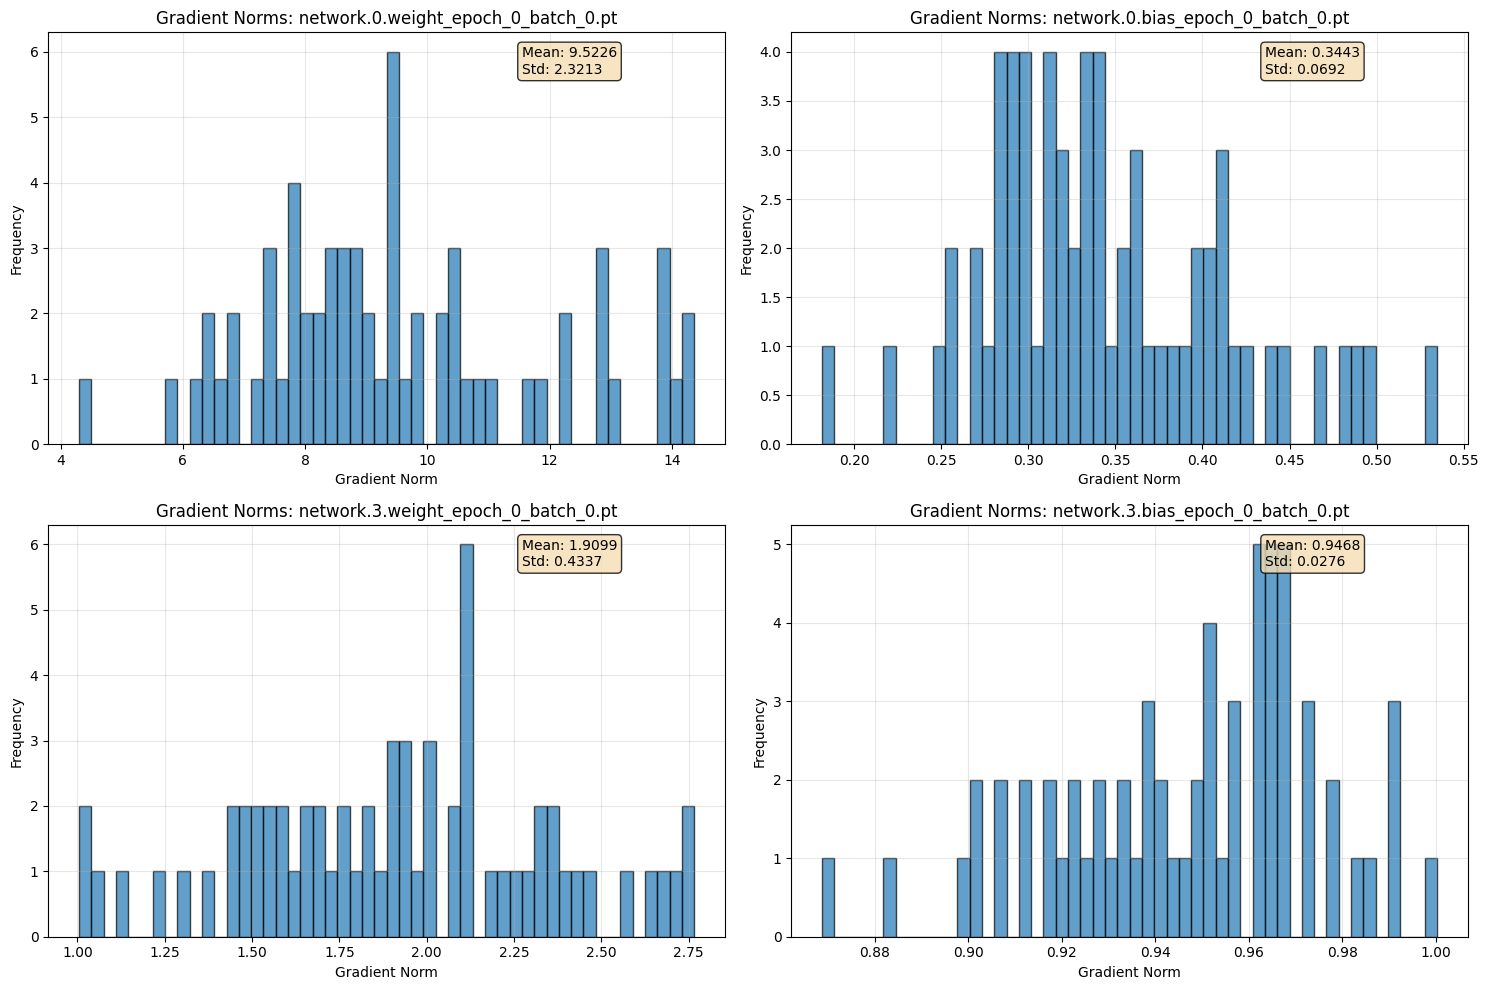

In [8]:
# Plot gradient norm distributions
if gradients_info:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (param_name, info) in enumerate(gradients_info.items()):
        if i >= 4:  # Limit to 4 plots
            break
            
        ax = axes[i]
        grad_norms = info['grad_norms'].numpy()
        
        ax.hist(grad_norms, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title(f'Gradient Norms: {param_name}')
        ax.set_xlabel('Gradient Norm')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        mean_norm = grad_norms.mean()
        std_norm = grad_norms.std()
        ax.text(0.7, 0.9, f'Mean: {mean_norm:.4f}\nStd: {std_norm:.4f}', 
                transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide unused subplots
    for i in range(len(gradients_info), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No gradients loaded to visualize.")

In [9]:
# Verify that all gradients have the same number of samples
if gradients_info:
    sample_counts = [info['num_samples'] for info in gradients_info.values()]
    unique_counts = set(sample_counts)
    
    print(f"\n📊 Sample count consistency:")
    print(f"  Unique sample counts: {unique_counts}")
    
    if len(unique_counts) == 1:
        print(f"  ✅ All parameters have the same number of samples: {list(unique_counts)[0]}")
    else:
        print(f"  ⚠️  Inconsistent sample counts across parameters!")
        
    # Check expected shape format
    print(f"\n🔍 Expected gradient shape format: [num_samples, *parameter_shape]")
    for param_name, info in gradients_info.items():
        expected_shape = (info['num_samples'],) + info['param_shape']
        actual_shape = info['gradients'].shape
        
        if expected_shape == actual_shape:
            print(f"  ✅ {param_name}: {actual_shape}")
        else:
            print(f"  ❌ {param_name}: Expected {expected_shape}, got {actual_shape}")


📊 Sample count consistency:
  Unique sample counts: {64, 32}
  ⚠️  Inconsistent sample counts across parameters!

🔍 Expected gradient shape format: [num_samples, *parameter_shape]
  ✅ network.0.weight_epoch_0_batch_0.pt: torch.Size([64, 32, 784])
  ✅ network.0.bias_epoch_0_batch_0.pt: torch.Size([64, 32])
  ✅ network.3.weight_epoch_0_batch_0.pt: torch.Size([64, 10, 32])
  ✅ network.3.bias_epoch_0_batch_0.pt: torch.Size([64, 10])
  ✅ network.0.weight_epoch_0_batch_1.pt: torch.Size([64, 32, 784])
  ✅ network.0.bias_epoch_0_batch_1.pt: torch.Size([64, 32])
  ✅ network.3.weight_epoch_0_batch_1.pt: torch.Size([64, 10, 32])
  ✅ network.3.bias_epoch_0_batch_1.pt: torch.Size([64, 10])
  ✅ network.0.weight_epoch_0_batch_2.pt: torch.Size([64, 32, 784])
  ✅ network.0.bias_epoch_0_batch_2.pt: torch.Size([64, 32])
  ✅ network.3.weight_epoch_0_batch_2.pt: torch.Size([64, 10, 32])
  ✅ network.3.bias_epoch_0_batch_2.pt: torch.Size([64, 10])
  ✅ network.0.weight_epoch_0_batch_3.pt: torch.Size([64, 32,

In [10]:
# Calculate memory usage
if gradients_info:
    total_memory = 0
    
    print(f"\n💾 Memory usage analysis:")
    for param_name, info in gradients_info.items():
        # Calculate memory in bytes
        num_elements = info['gradients'].numel()
        memory_bytes = num_elements * info['gradients'].element_size()
        memory_mb = memory_bytes / (1024 * 1024)
        
        total_memory += memory_mb
        
        print(f"  {param_name}: {memory_mb:.2f} MB ({num_elements:,} elements)")
    
    print(f"\n  Total memory: {total_memory:.2f} MB")
    
    # Estimate for full dataset
    if metadata:
        total_samples = metadata.get('total_samples', 0)
        if total_samples > 0:
            print(f"  Estimated memory for full MNIST (60,000 samples): {total_memory * 60000 / total_samples:.2f} MB")


💾 Memory usage analysis:
  network.0.weight_epoch_0_batch_0.pt: 6.12 MB (1,605,632 elements)
  network.0.bias_epoch_0_batch_0.pt: 0.01 MB (2,048 elements)
  network.3.weight_epoch_0_batch_0.pt: 0.08 MB (20,480 elements)
  network.3.bias_epoch_0_batch_0.pt: 0.00 MB (640 elements)
  network.0.weight_epoch_0_batch_1.pt: 6.12 MB (1,605,632 elements)
  network.0.bias_epoch_0_batch_1.pt: 0.01 MB (2,048 elements)
  network.3.weight_epoch_0_batch_1.pt: 0.08 MB (20,480 elements)
  network.3.bias_epoch_0_batch_1.pt: 0.00 MB (640 elements)
  network.0.weight_epoch_0_batch_2.pt: 6.12 MB (1,605,632 elements)
  network.0.bias_epoch_0_batch_2.pt: 0.01 MB (2,048 elements)
  network.3.weight_epoch_0_batch_2.pt: 0.08 MB (20,480 elements)
  network.3.bias_epoch_0_batch_2.pt: 0.00 MB (640 elements)
  network.0.weight_epoch_0_batch_3.pt: 6.12 MB (1,605,632 elements)
  network.0.bias_epoch_0_batch_3.pt: 0.01 MB (2,048 elements)
  network.3.weight_epoch_0_batch_3.pt: 0.08 MB (20,480 elements)
  network.3.bi

In [11]:
print("\n📋 Summary:")
print(f"  Epoch inspected: {EPOCH_TO_INSPECT}")
print(f"  Parameters with gradients: {len(gradients_info)}")

if gradients_info:
    # Get sample count from first parameter
    first_param = list(gradients_info.values())[0]
    print(f"  Samples per parameter: {first_param['num_samples']}")
    
    # List all parameter names
    param_names = list(gradients_info.keys())
    print(f"  Parameter names: {param_names}")
    
    print("\n✅ Gradient inspection completed successfully!")


📋 Summary:
  Epoch inspected: 0
  Parameters with gradients: 3752
  Samples per parameter: 64
  Parameter names: ['network.0.weight_epoch_0_batch_0.pt', 'network.0.bias_epoch_0_batch_0.pt', 'network.3.weight_epoch_0_batch_0.pt', 'network.3.bias_epoch_0_batch_0.pt', 'network.0.weight_epoch_0_batch_1.pt', 'network.0.bias_epoch_0_batch_1.pt', 'network.3.weight_epoch_0_batch_1.pt', 'network.3.bias_epoch_0_batch_1.pt', 'network.0.weight_epoch_0_batch_2.pt', 'network.0.bias_epoch_0_batch_2.pt', 'network.3.weight_epoch_0_batch_2.pt', 'network.3.bias_epoch_0_batch_2.pt', 'network.0.weight_epoch_0_batch_3.pt', 'network.0.bias_epoch_0_batch_3.pt', 'network.3.weight_epoch_0_batch_3.pt', 'network.3.bias_epoch_0_batch_3.pt', 'network.0.weight_epoch_0_batch_4.pt', 'network.0.bias_epoch_0_batch_4.pt', 'network.3.weight_epoch_0_batch_4.pt', 'network.3.bias_epoch_0_batch_4.pt', 'network.0.weight_epoch_0_batch_5.pt', 'network.0.bias_epoch_0_batch_5.pt', 'network.3.weight_epoch_0_batch_5.pt', 'network.3